In [1]:
!pip install split-folders

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import PIL
import pathlib
import splitfolders
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2


In [3]:
splitfolders.ratio("/kaggle/input/skin-cancer1/Skin cancer",
                   output="/kaggle/working/dataset_split",
                   ratio=(0.7, 0.15, 0.15))

Copying files: 2357 files [00:27, 85.35 files/s] 


In [4]:
data_dir_train = pathlib.Path( '/kaggle/working/dataset_split/train')
img_height,  img_width  = 299, 299

In [5]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed = 123,
                                        image_size=(img_height, img_width))

Found 1646 files belonging to 9 classes.


In [6]:
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

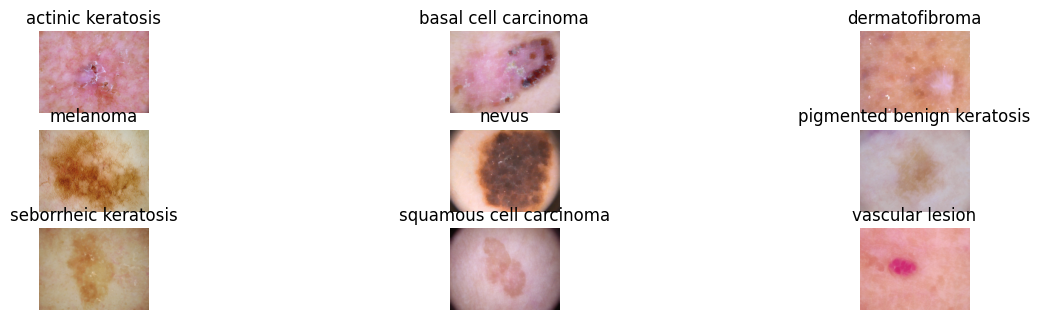

In [7]:
### Visualizing the training data
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(8, 3, i+1)

    # Correct indentation for the following lines
    data_path = os.path.join(str(data_dir_train), class_)
    file_paths = glob.glob(os.path.join(data_path, '*.*'))
    random_img_path = random.choice(file_paths)
    img = PIL.Image.open(random_img_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")

plt.show()

In [8]:
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.*')))

class_size

{'actinic keratosis': 91,
 'basal cell carcinoma': 274,
 'dermatofibroma': 77,
 'melanoma': 317,
 'nevus': 261,
 'pigmented benign keratosis': 334,
 'seborrheic keratosis': 56,
 'squamous cell carcinoma': 137,
 'vascular lesion': 99}

In [9]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,91
basal cell carcinoma,274
dermatofibroma,77
melanoma,317
nevus,261
pigmented benign keratosis,334
seborrheic keratosis,56
squamous cell carcinoma,137
vascular lesion,99


In [10]:
!pip install Augmentor

In [11]:
import Augmentor

In [12]:
path_to_training_dataset = '/kaggle/working/dataset_split/train/'
target_samples = 300  # Desired number of samples per class

for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    existing_samples = len(os.listdir(class_path))  # Count existing images
    additional_samples = max(0, target_samples - existing_samples)  # Calculate needed samples

    if additional_samples > 0:
        p = Augmentor.Pipeline(class_path, output_directory='')

        # 1.Rotation
        p.rotate(probability=0.9, max_left_rotation=25, max_right_rotation=25)

        # 2. Horizontal & Vertical Flip
        p.flip_left_right(probability=0.8)
        p.flip_top_bottom(probability=0.5)

        # 3. Random Zoom
        p.zoom_random(probability=0.4, percentage_area=0.5)

        # 4. Random Brightness
        p.random_brightness(probability=0.5, min_factor=0.4, max_factor=1.8)

        # 5. Random Contrast
        p.random_contrast(probability=0.4, min_factor=0.3, max_factor=2.0)


        # 7. Shearing
        p.shear(probability=0.4, max_shear_left=20, max_shear_right=20)

        # 8. Skewing
        p.skew(probability=0.4, magnitude=0.5)

        # 9. Gaussian Noise
        p.gaussian_distortion(probability=0.3, grid_width=5, grid_height=5, magnitude=8, corner='bell', method='in')

      

        # 12. Crop & Resize (For additional variation)
        p.crop_random(probability=0.3, percentage_area=0.7)
        p.resize(probability=1.0, width=299, height=299)

      

        # Generate only the necessary number of images
        p.sample(additional_samples)

Initialised with 91 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7BC430F418D0>: 100%|██████████| 209/209 [00:08<00:00, 23.64 Samples/s]


Initialised with 274 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7BC4304848B0>: 100%|██████████| 26/26 [00:00<00:00, 26.47 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7BC430484430>: 100%|██████████| 223/223 [01:06<00:00,  3.37 Samples/s] 


Initialised with 261 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/nevus/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7BC4303F47F0>: 100%|██████████| 39/39 [00:09<00:00,  4.29 Samples/s]


Initialised with 56 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7BC430379270>: 100%|██████████| 244/244 [00:24<00:00,  9.90 Samples/s]


Initialised with 137 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7BC460D03DC0>: 100%|██████████| 163/163 [00:39<00:00,  4.11 Samples/s]


Initialised with 99 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7BC430F41C00>: 100%|██████████| 201/201 [00:08<00:00, 22.64 Samples/s]


In [13]:
batch_size = 32
img_size = 299

In [14]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,
                               # horizontal flip
                                   brightness_range=[0.2,0.8])

test_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])
training_set = train_datagen.flow_from_directory('/kaggle/working/dataset_split/train',
                                               target_size=(299,299),
                                                 batch_size=32)

test_set = test_datagen.flow_from_directory('/kaggle/working/dataset_split/val',
                                            target_size=(299,299),
                                            batch_size=32,
                                            shuffle=False)

Found 2751 images belonging to 9 classes.
Found 349 images belonging to 9 classes.


In [15]:
pip install focal-loss

Note: you may need to restart the kernel to use updated packages.


In [25]:
def Xception_finetune(weights_path):
    
    base_model = Xception(weights=None, include_top=False, input_shape=(299, 299, 3))
    
    base_model.load_weights(weights_path)

    base_model.trainable = False

    x = base_model.output
    

    # Add new classifier head
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    new_output = layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=new_output)
    # Use Categorical Focal Loss with alpha and gamma parameters
    focal_loss_func = CategoricalFocalCrossentropy(gamma=2.0)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss=focal_loss_func,
        metrics=['accuracy']
    )

    return model, base_model


In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=3,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [18]:
filepath = '/kaggle/working/checkpoint/skincancer_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath , save_best_only= True, monitor = 'val_accuracy')

In [19]:
os.makedirs('/kaggle/working/Models/categories/', exist_ok=True)

In [29]:
def train():
    time_start = time.time()

    # Initialize the model
    model, base_model = Xception_finetune(
        weights_path='/kaggle/input/weights/tensorflow2/default/1/category.weights.h5'
    )
    model.summary()

    # Phase 1: Train only the new top layers (all base layers frozen)
    print("\nPhase 1: Training top layers only...")

    history_all = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    history = model.fit(
        training_set,
        epochs=5,
        validation_data=test_set,
        callbacks=[early_stopping, learning_rate_reduction, reduce_lr, checkpoint]
    )

    for key in history.history:
        if key not in history_all:
            history_all[key] = []
        history_all[key] += history.history[key]

    # Prepare for progressive unfreezing
    total_layers = len(model.layers)
    unfrozen = 5
    max_unfreeze = 60
    phase = 2

    while unfrozen < total_layers and unfrozen <= max_unfreeze:
        print(f"\nPhase {phase}: Unfreezing last {unfrozen} layers...")

        for layer in model.layers[-unfrozen:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

        history = model.fit(
            training_set,
            epochs=5,
            validation_data=test_set,
            callbacks=[early_stopping, learning_rate_reduction, checkpoint]
        )

        for key in history.history:
            if key not in history_all:
                history_all[key] = []
            history_all[key] += history.history[key]

        unfrozen += 5
        phase += 1

    model.save_weights('/kaggle/working/Models/categories/Skin_cancer.weights.h5')
    model.save('/kaggle/working/Models/categories/Skin_cancer.h5')

    print('Model saved.')
    print('Training Time:', time.time() - time_start)
    print('\n')

    return history_all


In [22]:
from tensorflow.keras.models import load_model

def test():
    #test_labels = np.array(test_labels)

    from tensorflow import keras
    print('Testing:')
    mod = load_model('/kaggle/working/Models/categories/Skin_cancer.h5')
    mod.evaluate(test_set)

    prob = mod.predict(test_set)
    predIdxs = np.argmax(prob, axis=1)


    print('\n')
    print(classification_report(test_set.labels, predIdxs,target_names = key, digits=5))
    return  prob, predIdxs, mod

In [23]:
input_path = '/kaggle/working/dataset_split/val'
train_data = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(299, 299))

Found 349 files belonging to 9 classes.


In [30]:
def plot_training_history(history_all):
    # Initialize full metric lists
    loss = []
    val_loss = []
    accuracy = []
    val_accuracy = []

    # Collect metrics from each history object
    for h in history_all:
        loss += h.history['loss']
        val_loss += h.history['val_loss']
        accuracy += h.history['accuracy']
        val_accuracy += h.history['val_accuracy']

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    key = train_data.class_names
    train_history = train()
    prob, predIdxs, model = test()

    # Plot training history
    plot_training_history(train_history)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,133,105 (80.62 MB)

 Trainable params: 267,529 (1.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)


Phase 1: Training top layers only...
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 94s 943ms/step - accuracy: 0.1848 - loss: 2.8774 - val_accuracy: 0.2779 - val_loss: 2.2757 - learning_rate: 3.0000e-04
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 885ms/step - accuracy: 0.2965 - loss: 2.0840 - val_accuracy: 0.4069 - val_loss: 1.7084 - learning_rate: 3.0000e-04
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 79s 850ms/step - accuracy: 0.3599 - loss: 1.5465 - val_accuracy: 0.4556 - val_loss: 1.2926 - learning_rate: 3.0000e-04
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 79s 856ms/step - accuracy: 0.3859 - loss: 1.1735 - val_accuracy: 0.3926 - val_loss: 1.0000 - learning_rate: 3.0000e-04

Phase 2: Unfreezing last 5 layers...
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 873ms/step - accuracy: 0.3852 - loss: 0.9311 - val_accuracy: 0.4011 - val_loss: 0.7955 - learning_rate: 3.0000e-04
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 872ms/step - accuracy: 0.4190 - loss: 0.7577 - val_accuracy: 0.4613 - val_loss: 0.6535 - learning_rate:

AttributeError: 'str' object has no attribute 'history'

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report

# Define test data generator for final testing
final_test_datagen = ImageDataGenerator(rescale=1./255)

# Load final test set
final_test_set = final_test_datagen.flow_from_directory('/kaggle/working/dataset_split/test/',
                                                        target_size=(299, 299),
                                                        batch_size=32,
                                                        shuffle=False)

# Load the model
mod = load_model('/kaggle/working/Models/categories/Skin_cancer.h5')

# Evaluate the model on the final test set
final_test_loss, final_test_accuracy = mod.evaluate(final_test_set)
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

# Predicting and classification report
prob = mod.predict(final_test_set)
predIdxs = np.argmax(prob, axis=1)

# Get class names from class indices
class_names = list(final_test_set.class_indices.keys())

# Print classification report
print(classification_report(final_test_set.classes, predIdxs, target_names=class_names))


Found 362 images belonging to 9 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4586 - loss: 0.3202 
Final Test Loss: 0.3152357041835785
Final Test Accuracy: 0.450276255607605
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.40      0.10      0.16        20
      basal cell carcinoma       0.57      0.48      0.52        60
            dermatofibroma       1.00      0.17      0.29        18
                  melanoma       0.45      0.88      0.59        69
                     nevus       0.32      0.40      0.35        57
pigmented benign keratosis       0.46      0.49      0.48        73
      seborrheic keratosis       0.00      0.00      0.00        12
   squamous cell carcinoma       0.25      0.03      0.06        31
           vascular lesion       0.73      0.36      0.48        22

                  accuracy                           0.45       362
                 macro avg       0.46      0.33      0.33   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


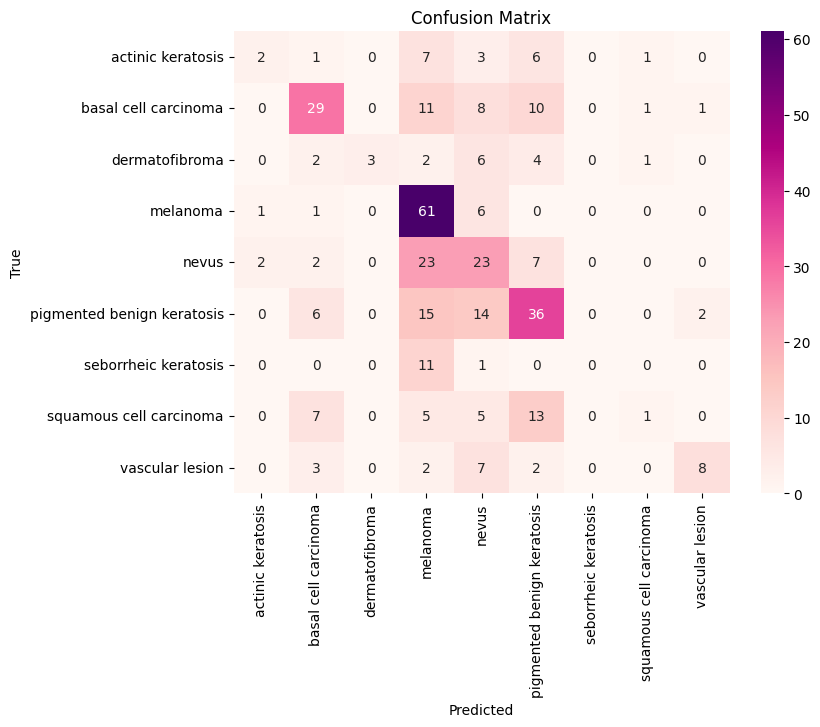

In [58]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(final_test_set.classes, predIdxs)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [60]:

def plot_training_history(history_all):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_all['loss'], label='Training Loss')
    plt.plot(history_all['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_all['accuracy'], label='Training Accuracy')
    plt.plot(history_all['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


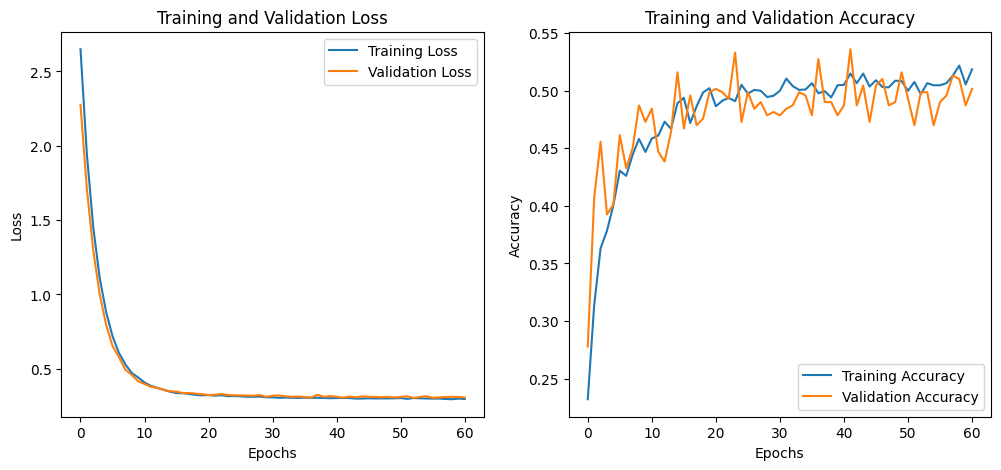

In [61]:
plot_training_history(train_history)
